In [1]:
import tensorflow as tf
import numpy as np
import cv2

2024-07-02 15:33:17.439481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
test_image =cv2.cvtColor(cv2.imread('img.jpg'),cv2.COLOR_BGR2RGB)

test_image = cv2.resize(test_image, (256,256))

In [3]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                                    sizes=[1, 16, 16, 1],
                                    strides = [1, 16, 16, 1],
                                    rates = [1, 1, 1, 1],
                                    padding = 'VALID')

2024-07-02 15:33:19.518656: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
print(patches.shape)

(1, 16, 16, 768)


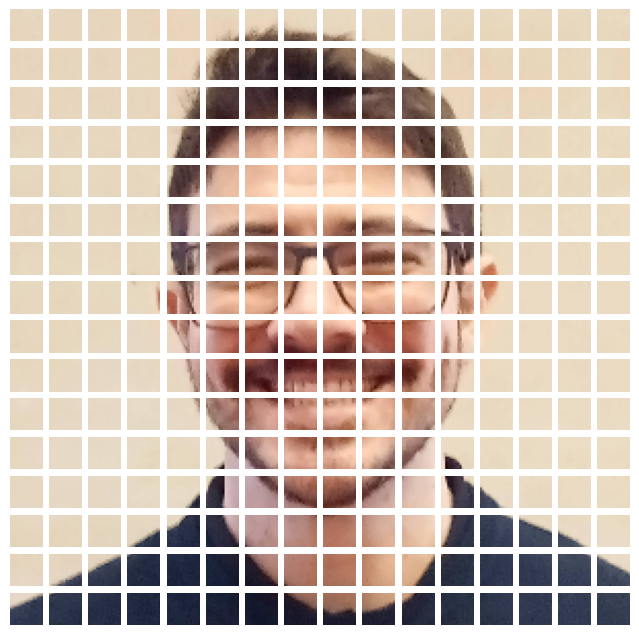

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
k=0
for i in range(16):
    for j in range(16):
        
        ax = plt.subplot(16,16,k+1)
        plt.imshow(tf.reshape(patches[0,i,j,:], (16,16,3)))
        plt.axis('off')
        k+=1

In [16]:
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Layer

class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE):
        super(PatchEncoder, self).__init__(name='patch_encoder')


        self.linear_projection = Dense(HIDDEN_SIZE)
        self.positional_emb = Embedding(N_PATCHES, HIDDEN_SIZE)
        self.N_PATCHES = N_PATCHES
        
    def call(self, x):
        patches = tf.image.extract_patches(images=x,
                                sizes=[1, 16, 16, 1],
                                strides = [1, 16, 16, 1],
                                rates = [1, 1, 1, 1],
                                padding = 'VALID')
        
        patches = tf.reshape(patches, (patches.shape[0], -1, 768))
        embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1)
        output = self.linear_projection(patches) + self.positional_emb(embedding_input)

        return output


In [17]:
patch_enc = PatchEncoder(256, 768)
patch_enc(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[ 0.04225496, -0.0304908 ,  0.03246274, ...,  0.04103538,
          0.00375139,  0.02053   ],
        [-0.0350764 , -0.00732142, -0.03070921, ...,  0.03638751,
         -0.0136521 , -0.00281046],
        [ 0.03411654,  0.03561426, -0.02416507, ..., -0.02547295,
         -0.0007113 , -0.04138904],
        ...,
        [ 0.00130989, -0.04318024,  0.01787912, ..., -0.03103855,
          0.0393716 ,  0.04882506],
        [ 0.02534206,  0.01186565, -0.01764246, ..., -0.00965464,
         -0.00793453, -0.0011136 ],
        [ 0.02479683, -0.04845394, -0.03232636, ...,  0.00411453,
          0.03435694,  0.01665336]]], dtype=float32)>

In [25]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add
class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE):
        super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()


        self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)
        self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
        self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

    def call(self,input):

        x_1 = self.layer_norm1(input)
        x_1 = self.multi_head_att(x_1,x_1)

        x_1 = Add()([x_1,input])

        x_2 = self.layer_norm2(x_1)
        x_2 = self.dense_1(x_2)
        output = self.dense_2(x_2)
        output = Add()([output,x_1])
        return output

In [26]:
trans_enc = TransformerEncoder(8,768)
trans_enc(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

In [31]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Flatten

class Vit(Model):
    def __init__(self,N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS, NUM_CLASSES):
        super(Vit,self).__init__(name = 'vision_transformer')
        
        self.N_LAYERS = N_LAYERS
        self.patch_encoder = PatchEncoder(N_PATCHES,HIDDEN_SIZE)
        self.transf_encoder = [TransformerEncoder(N_HEADS,HIDDEN_SIZE) for _ in range(N_LAYERS)]
        self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
        self.dense_3 = Dense(NUM_CLASSES, activation = 'softmax')
    def call(self,input, training = True):

        x = self.patch_encoder(input)


        for i in range(self.N_LAYERS):
            x = self.transf_encoder[i](x)
        
        x = Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        output = self.dense_3(x)

        return output

In [42]:
input_shape = (1, 256, 256, 3)
vit = Vit(N_HEADS=8, HIDDEN_SIZE=768, N_PATCHES=256, N_LAYERS=6, N_DENSE_UNITS=128, NUM_CLASSES=10)

vit.build(input_shape)

In [43]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncoder  multiple                 787200    
 )                                                               
                                                                 
 transformer_encoder (Transf  multiple                 20077824  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple                 20077824  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple                 20077824  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple          

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding, LayerNormalization, MultiHeadAttention, Add, Flatten, Input
from tensorflow.keras.models import Model

class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE):
        super(PatchEncoder, self).__init__(name='patch_encoder')
        self.linear_projection = Dense(HIDDEN_SIZE)
        self.positional_emb = Embedding(N_PATCHES, HIDDEN_SIZE)
        self.N_PATCHES = N_PATCHES

    def call(self, x):
        batch_size = tf.shape(x)[0]
        patches = tf.image.extract_patches(images=x,
                                           sizes=[1, 16, 16, 1],
                                           strides=[1, 16, 16, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches = tf.reshape(patches, (batch_size, -1, patches.shape[-1]))
        embedding_input = tf.range(start=0, limit=self.N_PATCHES, delta=1)
        output = self.linear_projection(patches) + self.positional_emb(embedding_input)
        return output

class TransformerEncoder(Layer):
    def __init__(self, N_HEADS, HIDDEN_SIZE,i):
        super(TransformerEncoder, self).__init__(name='transformer_encoder'+str(i))
        self.layer_norm1 = LayerNormalization()
        self.layer_norm2 = LayerNormalization()
        self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE)
        self.dense_1 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)
        self.dense_2 = Dense(HIDDEN_SIZE, activation=tf.nn.gelu)

    def call(self, input):
        x_1 = self.layer_norm1(input)
        x_1 = self.multi_head_att(x_1, x_1)
        x_1 = Add()([x_1, input])
        x_2 = self.layer_norm2(x_1)
        x_2 = self.dense_1(x_2)
        output = self.dense_2(x_2)
        output = Add()([output, x_1])
        return output

def create_vit_model(input_shape, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS, NUM_CLASSES):
    inputs = Input(shape=input_shape)
    x = PatchEncoder(N_PATCHES, HIDDEN_SIZE)(inputs)
    for i in range(N_LAYERS):
        x = TransformerEncoder(N_HEADS, HIDDEN_SIZE,i)(x)
    x = Flatten()(x)
    x = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)(x)
    x = Dense(N_DENSE_UNITS, activation=tf.nn.gelu)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

input_shape = (256, 256, 3)
vit = create_vit_model(input_shape, N_HEADS=8, HIDDEN_SIZE=768, N_PATCHES=256, N_LAYERS=2, N_DENSE_UNITS=128, NUM_CLASSES=10)
vit.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 patch_encoder (PatchEncoder  (None, 256, 768)         787200    
 )                                                               
                                                                 
 transformer_encoder0 (Trans  (None, 256, 768)         20077824  
 formerEncoder)                                                  
                                                                 
 transformer_encoder1 (Trans  (None, 256, 768)         20077824  
 formerEncoder)                                                  
                                                                 
 flatten_6 (Flatten)         (None, 196608)            0         
                                                           